logdir/model_final/models/gazeNET_0004_00003750.pth.tar
Loading model: logdir/model_final/models/gazeNET_0004_00003750.pth.tar
done.
Running testing
Predicting Kreuze_Random Recording1_short
[FP], n_samples: 1, dur: 3.35


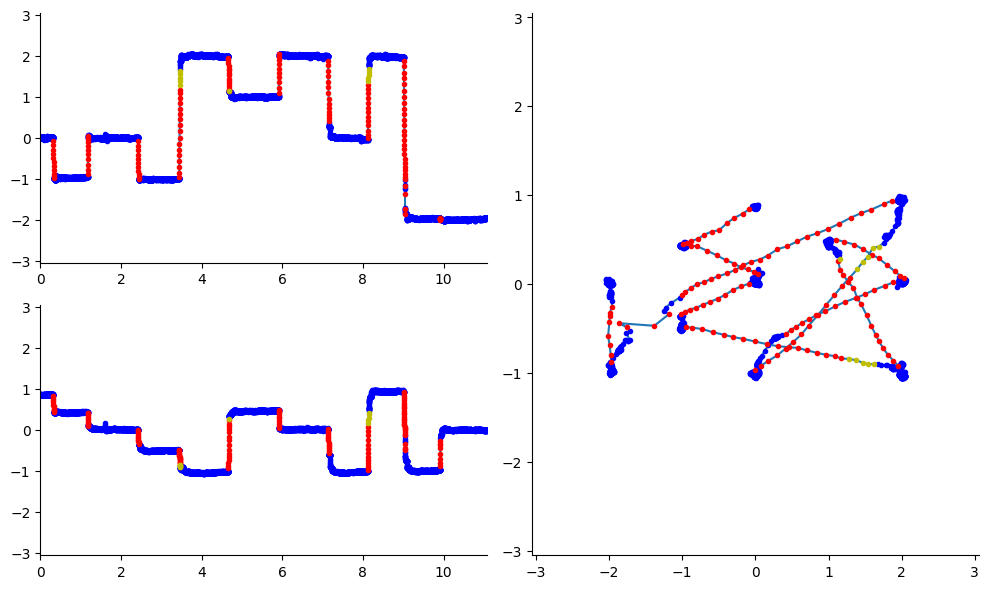

In [5]:
#%% imports
import os, sys
from distutils.dir_util import mkpath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()

###
import copy

from utils_lib.etdata import ETData
from utils_lib import utils
from utils_lib.data_loader import EMDataset, GazeDataLoader
from utils_lib.ETeval import run_infer

from model import gazeNET as gazeNET
import model as model_func


#%% init variables
dev = False
model_dir = 'model_final'
model_name = 'gazeNET_0004_00003750'

logdir =  os.path.join('logdir', model_dir)
fname_config = os.path.join(logdir, 'config.json')
if os.path.exists(fname_config):
    configuration = utils.Config(fname_config)
    config = configuration.params
else:
    print("No config file found in %s" % model_dir)
    sys.exit()

config['split_seqs']=False
config['augment']=False
config['batch_size']=1

cuda = False
model_name = '%s.pth.tar'%model_name

#%% prepare model
num_classes = len(config['events'])
model = gazeNET(config, num_classes)
model_func.load(model, model_dir, config, model_name)

model.eval()

#%%testing

print ("Running testing")
kwargs = {
    'cuda': False,
    'use_tqdm': False,
    'eval': False,
}

etdata_gt = ETData()
etdata_pr = ETData()

root = 'etdata'
dataset = 'tobii'
fname = 'Kreuze_Random Recording1_short'
fpath = '%s/%s/%s.npy'%(root, dataset, fname)
num_workers = 0

fdir, fname = os.path.split(os.path.splitext(fpath)[0])

#load data
X_test = np.load(fpath)
_status = np.isnan(X_test['x']) | \
        np.isnan(X_test['y']) | \
        ~np.in1d(X_test['evt'], config['events'])
X_test['status'] = ~_status
test_dataset = EMDataset(config = config, gaze_data = [X_test])
n_samples = len(test_dataset)

test_loader = GazeDataLoader(test_dataset, batch_size=config['batch_size'],
                            num_workers=num_workers,
                            shuffle=False)
#predict
print ("Predicting %s" % fname)

_gt, _pr, pr_raw = run_infer(model, n_samples, test_loader, **kwargs)

#glue back the predictions
_data_pr = copy.deepcopy(test_dataset.data)
for _d, _pred in zip(_data_pr, pr_raw):
    _d['evt'] = 0
    _d['evt'][1:] = np.argmax(_pred, axis=1)+1
_data_pr = pd.concat([pd.DataFrame(_d) for _d in _data_pr]).reset_index(drop=True)
_data = pd.DataFrame(X_test)
_data = _data.merge(_data_pr, on='t', suffixes=('', '_pred'), how='left')
_data['evt'] = _data['evt_pred'].replace({np.nan:0})

#save
etdata_pr.load(_data[['t', 'x', 'y', 'status', 'evt']].values, **{'source':'np_array'})

sdir = fdir.replace(dataset, '%s_gazeNet_copy'%dataset)
mkpath(sdir)
spath = '%s/%s'%(sdir, fname)
etdata_pr.save(spath)
etdata_pr.plot(show=True, save=False)


